<a href="https://colab.research.google.com/github/MarekSroka/SDA_projekty/blob/main/Prediction%20of%20debt%20repayments/MS_Final_project_v2_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Project description**



An important part of the debt collection industry is the prediction at the investment appraisal stage of whether the debtors in the portfolios purchased by the debt collection company will pay their debts. 

The set of debtors from whom a debt collection company is attempting to collect funds are clients at the enforcement stage. It has been established that this is a significant segment of the portfolios purchased and the share of these cases in the portfolio often determines significantly the price of the entire portfolio.


**The project objective:**

Prediction whether case has status will be paying after the purchase of the debt portfolio within 60 months (min. amount of payment = 120 zl) 



**Features description:**


wartosc_kredytu - initial product value

kapital - capital

zadluzenie_na_moment_wyceny - debt at time of valuation

populacja - the population of the place of residence

kategoria_produktu - product category

plec - gender

dpd - days past debts - oldest outstanding debt

czy_wind_zewn - external debt collection

wiek - age

liczba_dni_od_daty_umowy - number of days from contract date

liczba_dni_od_wypowiedzenia - number of days after termination

liczba_dni_od_wszczecia_egzekucji - number days from enforcement

suma_wplat_v - total history of payments from the vendor

suma_wplat_12m_v - total payments of the last 12 months from the vendor

paying - (target column) 

# Packages

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2

import joblib

!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


# Load data

In [ ]:
data_all = pd.read_csv('drive/MyDrive/1.Projekt_koncowy/data_all_02.csv', delimiter=',', index_col=[0])

# Support functions

Data analysis function

In [ ]:
def col_checker(df):
    print(df.info())
    print(df.describe())
    col = list(df.columns)
    print('Columns list:\n', col)   
    for c in col:
        print('\n', '-->column name:', c,'\n')
        print(df[c].value_counts(normalize=True))
        print('\n Number of nulls:', df[c].isna().sum())

Evaluation model function

In [ ]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'Accuracy', 'F1_score', 'AUC'])

models = []
models_names = []

def calculation_metrics(model, model_name):
    models.append(model)
    models_names.append(model_name)
    global metrics_dataframe
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)

    # Precision, Recall, F1
    print(classification_report(y_test, predictions))

    # ROC curve
    
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected in zip(models, models_names):
        fpr, tpr, thresholds = roc_curve(y_test, model_selected.predict_proba(X_test)[:,1]) 
        plt.plot(fpr, tpr, label=name_selected)
       
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title(f'ROC Curve')
    plt.legend()   
    plt.show()

    # Confusion matrix
    plt.figure()
    
    cm = confusion_matrix(y_test, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(f'\nConfusion matrics for {model_name}\n')
    plt.show()

    # AUC i F1 score
    accuracy = accuracy_score(y_test, predictions)
    f1score = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions_proba[:, 1])
    
    metrics_dataframe = metrics_dataframe.append({'Model': model_name, 'Accuracy': accuracy, 'F1_score': f1score, 'AUC': auc},
                                                 ignore_index=True)
    return metrics_dataframe

# EDA

In [ ]:
col_checker(data_all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112011 entries, 0 to 113602
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   wartosc_kredytu              112011 non-null  float64
 1   kapital                      112011 non-null  float64
 2   zadluzenie_na_moment_wyceny  112011 non-null  float64
 3   populacja                    112011 non-null  float64
 4   kategoria_produktu           112011 non-null  object 
 5   plec                         112011 non-null  object 
 6   dpd                          112011 non-null  float64
 7   czy_wind_zewn                112011 non-null  int64  
 8   wiek                         112011 non-null  float64
 9   liczba_dni_od_daty_umowy     111903 non-null  float64
 10  liczba_dni_od_wypowiedzenia  89741 non-null   float64
 11  suma_wplat_v                 110902 non-null  float64
 12  suma_wplat_12m_v             108739 non-null  float64
 13 

Elimination of cases with debt equal 0 - obviously incorrect data.

In [ ]:
data_all = data_all[data_all['zadluzenie_na_moment_wyceny'] > 0]

The values -999999.00 and -999997.00 in col suma_wplat_12m_v and suma_wplat_v for the designations in the database are obviously incorrect - they mean that no data has been submitted for valuation for these cases.Filling in these values with 0 - assumes no repayments.

Similarly, null values converted to 0.

In [ ]:
cond = data_all['suma_wplat_v'] < 0
cond_2 = data_all['suma_wplat_12m_v'] < 0

In [ ]:
data_all.loc[cond, 'suma_wplat_v'] = 0
data_all.loc[cond_2, 'suma_wplat_12m_v'] = 0

In [ ]:
data_all['suma_wplat_v'].fillna(0, inplace=True)
data_all['suma_wplat_12m_v'].fillna(0, inplace=True)

Null values in column liczba_dni_od_daty_umowy, liczba_dni_od_wypowiedzenia  are filled in with the mean value.

In [ ]:
data_all['liczba_dni_od_daty_umowy'].fillna(data_all['liczba_dni_od_daty_umowy'].median(), inplace=True)
data_all['liczba_dni_od_wypowiedzenia'].fillna(data_all['liczba_dni_od_wypowiedzenia'].median(), inplace=True)

# Feature Engineering

Creation of new features from existing ones:

the_ratio_credit_to_debt = the credit to debt ratio

In [ ]:
data_all['ratio_credit_to_debt'] = data_all['wartosc_kredytu'] / data_all['zadluzenie_na_moment_wyceny'] 

ratio_capital_to_debt = the capital to debt ratio

In [ ]:
data_all['ratio_capital_to_debt'] = data_all['kapital'] / data_all['zadluzenie_na_moment_wyceny'] 

ratio_sop_to_debt = ratio of all payments to debt 

In [ ]:
data_all['ratio_sop_to_debt'] = data_all['suma_wplat_v'] / data_all['zadluzenie_na_moment_wyceny']

ratio_sop12m_to_debt = ratio of 12 months payments to debt 

In [ ]:
data_all['ratio_sop12m_to_debt'] = data_all['suma_wplat_12m_v'] / data_all['zadluzenie_na_moment_wyceny']

share_12m_in_total = share of 12 monthly repayments in total repayments

In [ ]:
data_all['share_12m_in_total'] = data_all['suma_wplat_12m_v'].div(data_all['suma_wplat_v']).replace(np.inf, 0)
data_all.loc[~np.isfinite(data_all['share_12m_in_total']), 'share_12m_in_total'] = 0

time_debt_exist =  proportion of the duration of the contract with a status of unpaid debt

In [ ]:
data_all['time_debt_exist'] = data_all['dpd'] / data_all['liczba_dni_od_daty_umowy']

time_after_termin = proportion of the duration of the contract after agreement termination

In [ ]:
data_all['time_after_term'] = data_all['liczba_dni_od_wypowiedzenia'] / data_all['liczba_dni_od_daty_umowy']

time_on_booked - number of days of proper servicing of the commitment

In [ ]:
data_all['time_on_book'] = data_all['liczba_dni_od_daty_umowy'] - data_all['dpd']

For the further process, we select the newly created features, getting rid of the columns that formed the basis for their creation:

- wartosc_kredytu
- zadluzenie_na_moment_wyceny
- kapital
- suma_wplat_v
- suma_wplat_12m_v


In [ ]:
data_all_01 = data_all[['kategoria_produktu','plec',  'czy_wind_zewn', 'populacja', 'wiek', 'dpd','liczba_dni_od_daty_umowy', 'liczba_dni_od_wypowiedzenia','ratio_credit_to_debt', 'ratio_capital_to_debt',  'ratio_sop_to_debt', 'ratio_sop12m_to_debt', 'share_12m_in_total', 'time_debt_exist', 'time_after_term','time_on_book', 'paying']]

In [ ]:
data_all_01.reset_index(inplace=True)

In [ ]:
data_all_01.drop('index', axis=1, inplace=True)

New created columns nas some inappropriate negative values and these rows should be deleted.

In [ ]:
data_all_01.drop(data_all_01[data_all_01['time_on_book'] < 0].index, inplace=True)

**Completely stats and characteristics of final dataset:**

In [ ]:
col_checker(data_all_01)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111768 entries, 0 to 111783
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   kategoria_produktu           111768 non-null  object 
 1   plec                         111768 non-null  object 
 2   czy_wind_zewn                111768 non-null  int64  
 3   populacja                    111768 non-null  float64
 4   wiek                         111768 non-null  float64
 5   dpd                          111768 non-null  float64
 6   liczba_dni_od_daty_umowy     111768 non-null  float64
 7   liczba_dni_od_wypowiedzenia  111768 non-null  float64
 8   ratio_credit_to_debt         111768 non-null  float64
 9   ratio_capital_to_debt        111768 non-null  float64
 10  ratio_sop_to_debt            111768 non-null  float64
 11  ratio_sop12m_to_debt         111768 non-null  float64
 12  share_12m_in_total           111768 non-null  float64
 13 

In [ ]:
data_all_02 = data_all_01.copy()

Splitting data into X and y (target).

In [ ]:
y = data_all_02.pop('paying')
y

In [ ]:
X = data_all_02
X.head()

Splitting data into numeric and categorical sets

In [ ]:
X['czy_wind_zewn'] = X['czy_wind_zewn'].astype(str)
cat_feat = X.select_dtypes(include="object").columns
print(f'Categorical features: {cat_feat}')

num_feat = ['populacja', 'wiek', 'dpd','liczba_dni_od_daty_umowy', 'liczba_dni_od_wypowiedzenia', 
            'ratio_credit_to_debt', 'ratio_capital_to_debt',  'ratio_sop_to_debt', 'ratio_sop12m_to_debt', 'share_12m_in_total', 'time_debt_exist', 'time_after_term', 'time_on_book']
print(f'\nNumerical features: {num_feat}')

Categorical features: Index(['kategoria_produktu', 'plec', 'czy_wind_zewn'], dtype='object')

Numerical features: ['populacja', 'wiek', 'dpd', 'liczba_dni_od_daty_umowy', 'liczba_dni_od_wypowiedzenia', 'ratio_credit_to_debt', 'ratio_capital_to_debt', 'ratio_sop_to_debt', 'ratio_sop12m_to_debt', 'share_12m_in_total', 'time_debt_exist', 'time_after_term', 'time_on_book']


# Data Visualization

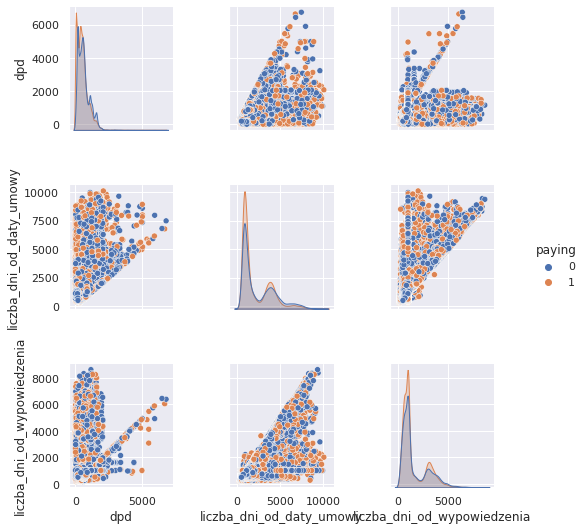

In [ ]:
sns.set(rc={"figure.figsize":(25, 10)})
data_days =  ['dpd','liczba_dni_od_daty_umowy', 'liczba_dni_od_wypowiedzenia', 'paying']

sns.pairplot(data_all_01[data_days], hue="paying")

plt.show()

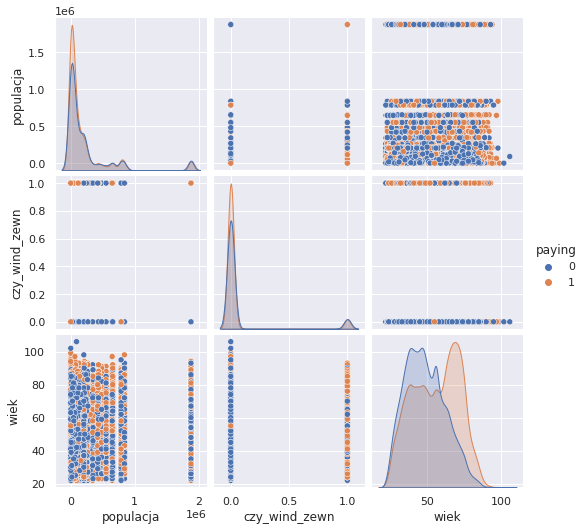

In [ ]:
data_cat =  ['populacja', 'plec',  'czy_wind_zewn', 'wiek', 'paying']

sns.pairplot(data_all_01[data_cat], hue="paying")

plt.show()

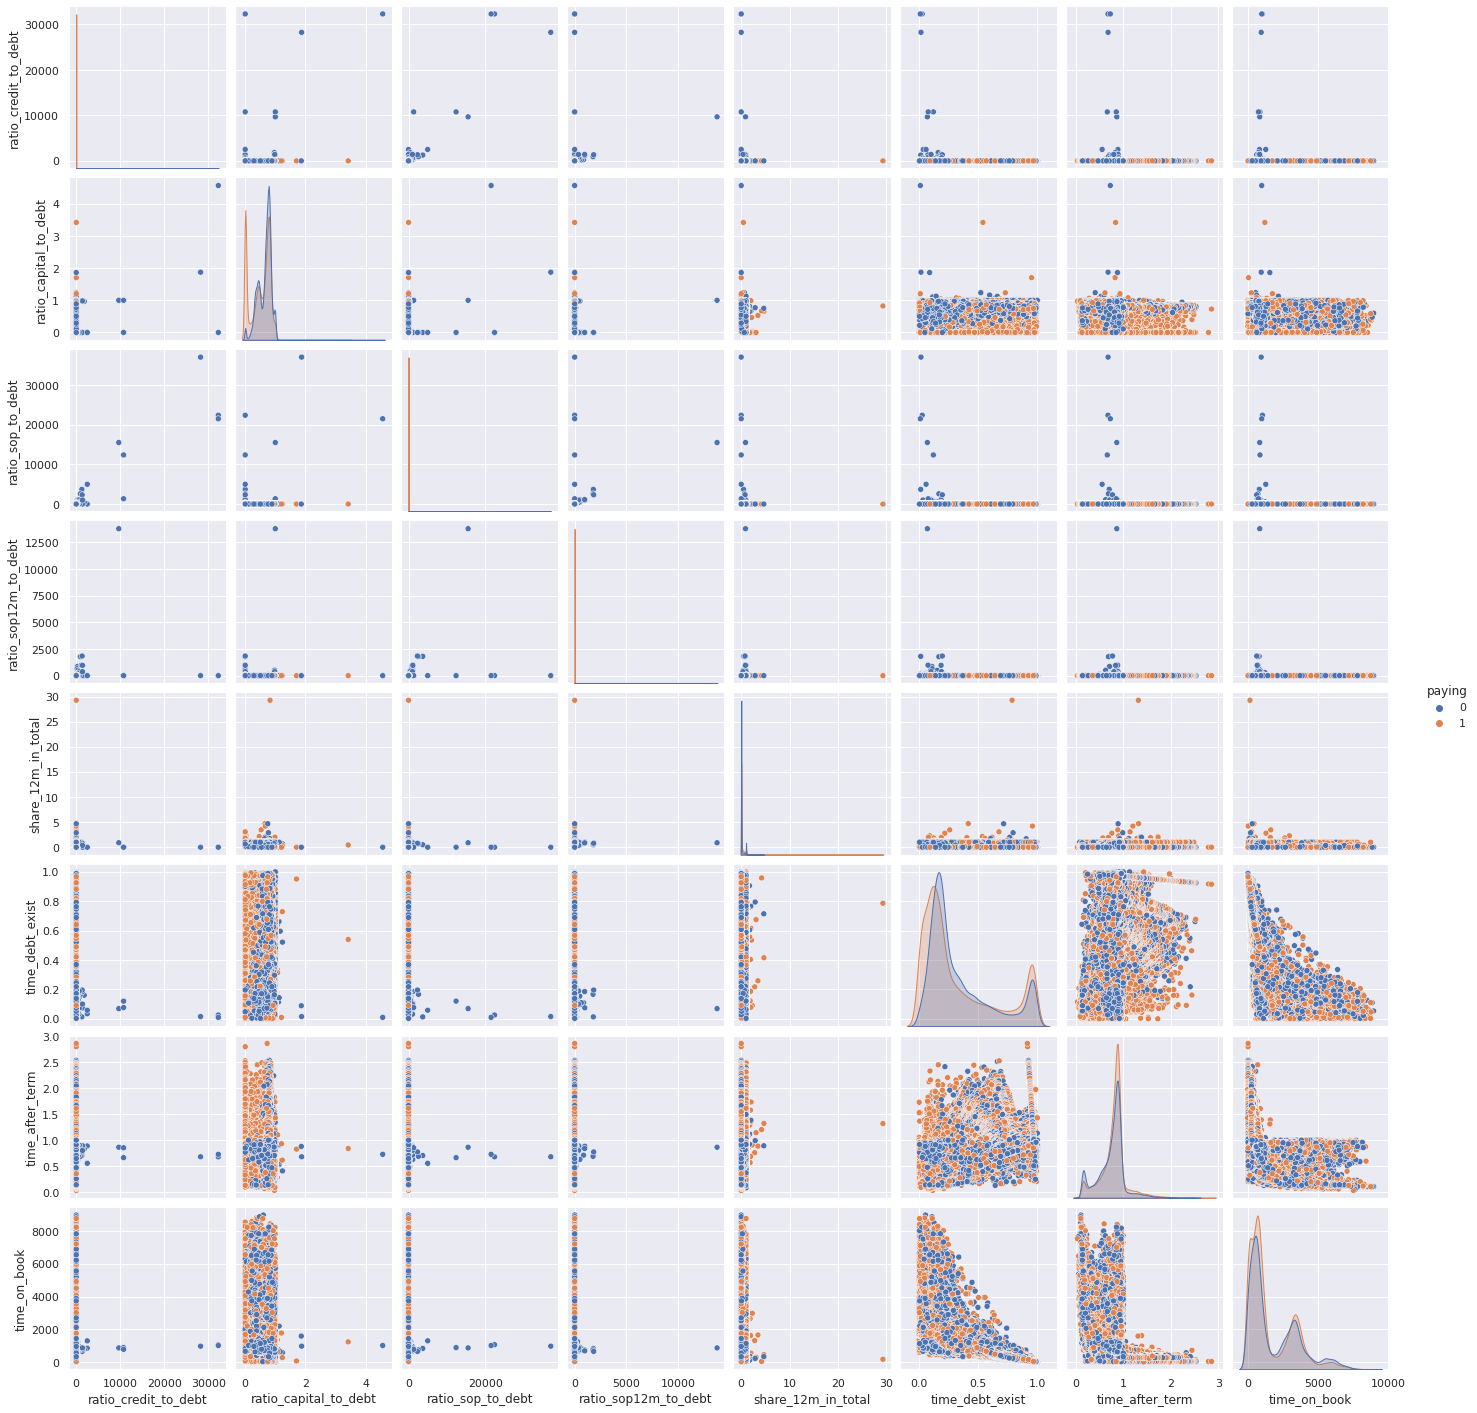

In [ ]:
data_ratios = ['ratio_credit_to_debt', 'ratio_capital_to_debt',  'ratio_sop_to_debt', 'ratio_sop12m_to_debt', 'share_12m_in_total', 'time_debt_exist', 'time_after_term', 'time_on_book', 'paying']

sns.pairplot(data_all_01[data_ratios], hue="paying")

plt.show()

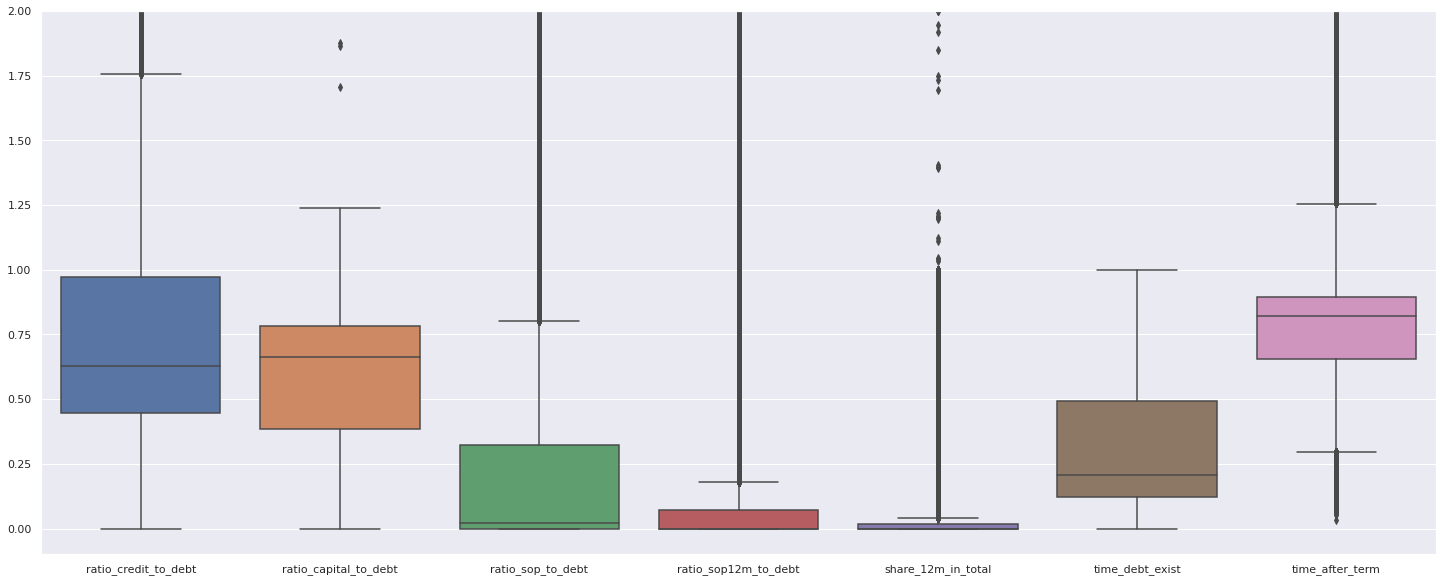

In [ ]:
df_ratios_2 = pd.DataFrame(data=data_all_01, columns=['ratio_credit_to_debt', 'ratio_capital_to_debt',  'ratio_sop_to_debt', 'ratio_sop12m_to_debt', 'share_12m_in_total', 'time_debt_exist', 'time_after_term'])

sns.set(rc={"figure.figsize":(25, 10)})

sns.boxplot(data=df_ratios_2)
plt.ylim(-0.1, 2)
plt.show()

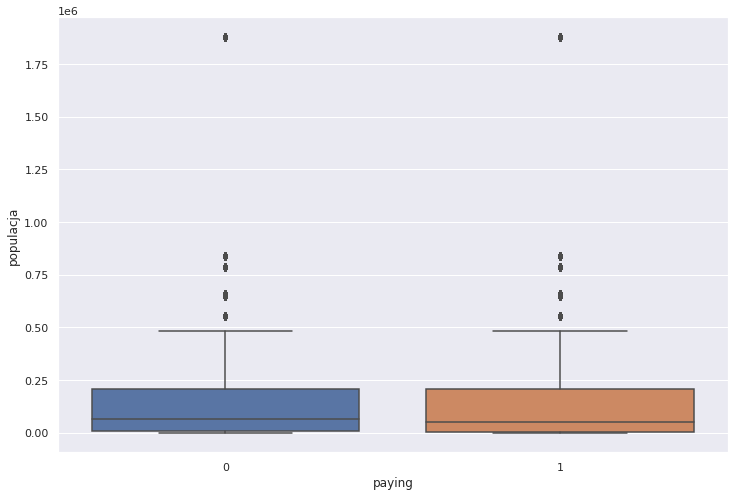

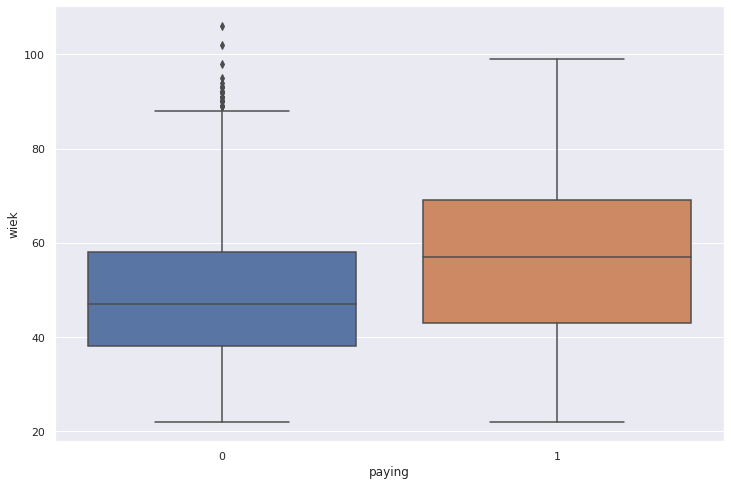

In [ ]:
num_feat_01 = ['populacja', 'wiek'] 
            
for f in num_feat_01:
  plt.figure(figsize=(12, 8))
  sns.boxplot(x=y, y=X[f])
  plt.show()

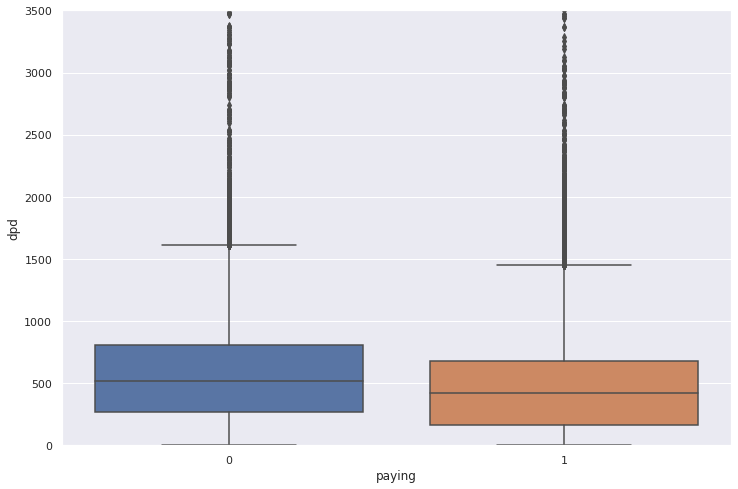

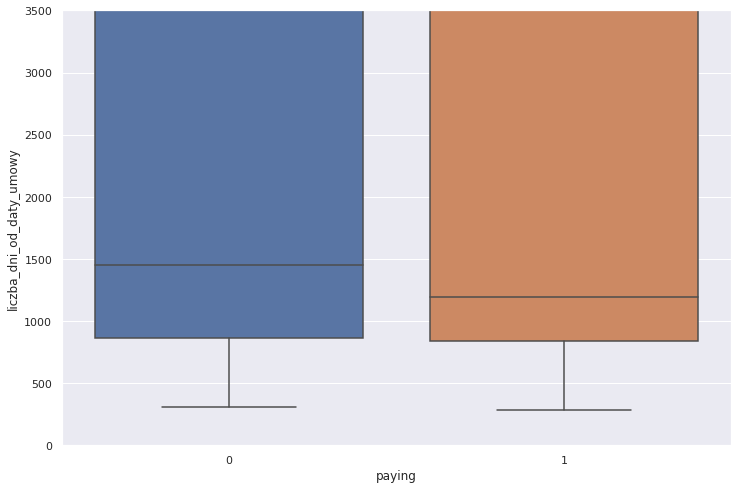

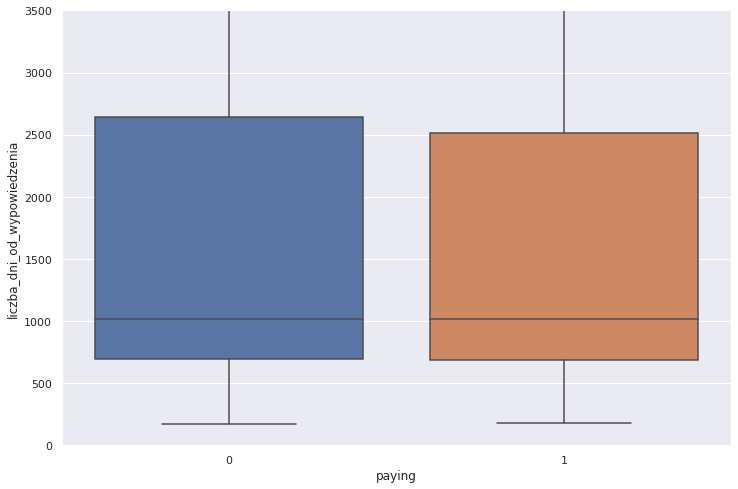

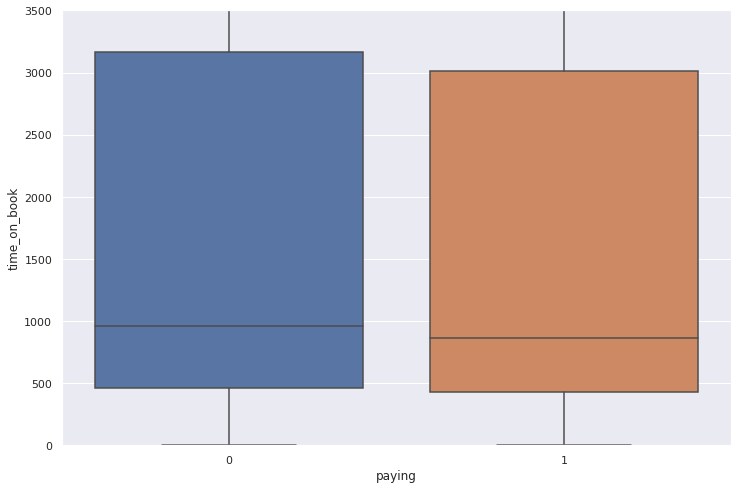

In [ ]:
num_feat_02 = ['dpd', 'liczba_dni_od_daty_umowy', 'liczba_dni_od_wypowiedzenia', 'time_on_book']

for f in num_feat_02:
  plt.figure(figsize=(12, 8))
  sns.boxplot(x=y, y=X[f])
  plt.ylim((0, 3500))
  plt.show()

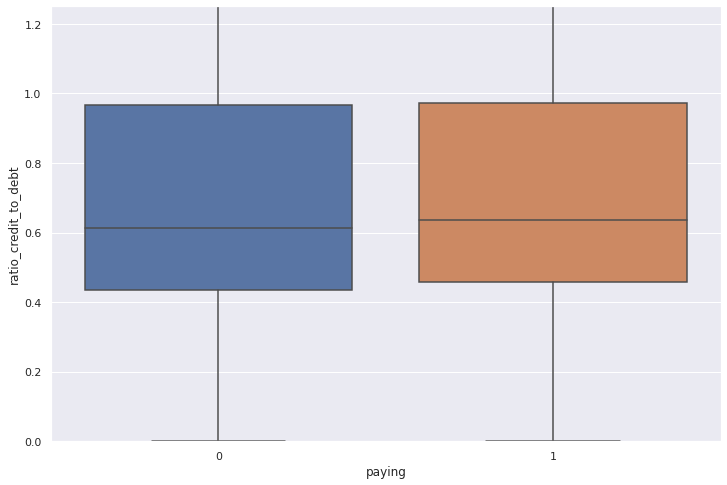

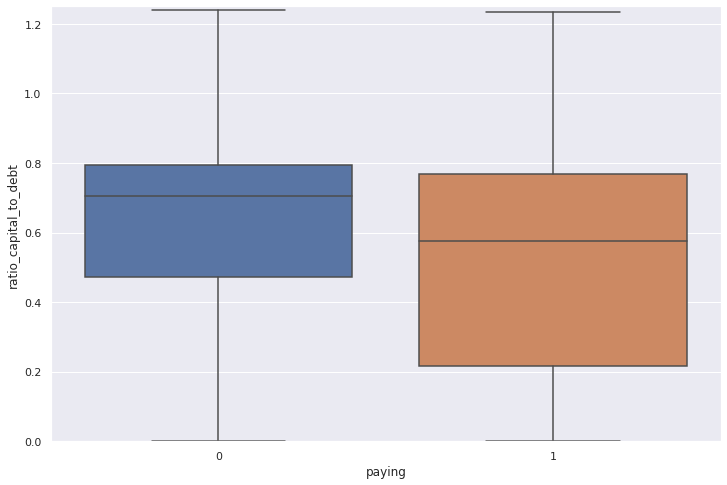

In [ ]:
num_feat_03 = ['ratio_credit_to_debt', 'ratio_capital_to_debt']

for f in num_feat_03:
  plt.figure(figsize=(12, 8))
  sns.boxplot(x=y, y=X[f])
  plt.ylim((0, 1.25))
  plt.show()

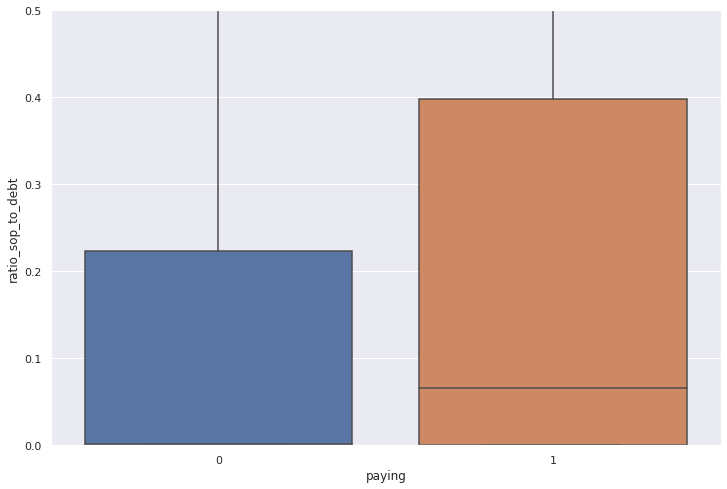

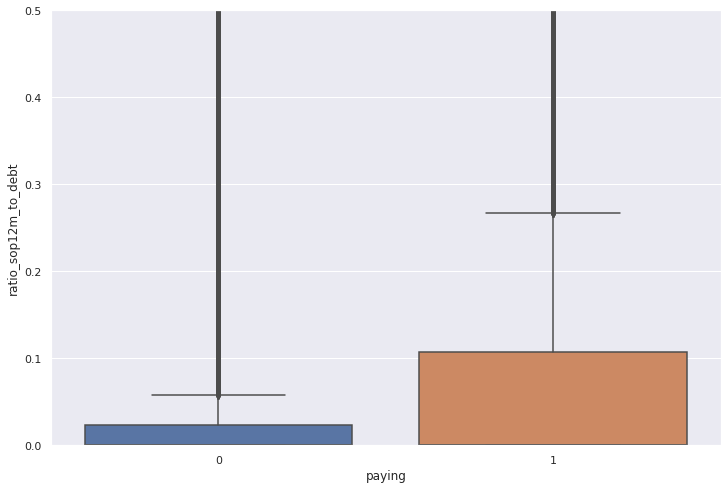

In [ ]:
num_feat_04 = ['ratio_sop_to_debt', 'ratio_sop12m_to_debt']

for f in num_feat_04:
  plt.figure(figsize=(12, 8))
  sns.boxplot(x=y, y=X[f])
  plt.ylim((0, 0.5))
  plt.show()

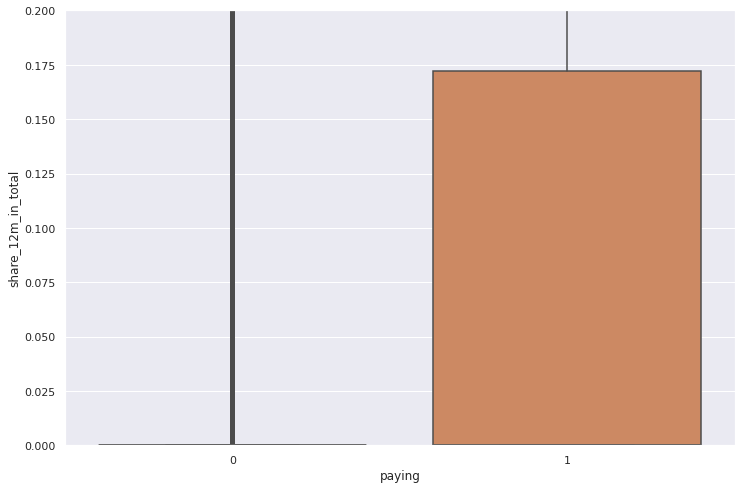

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=y, y=X['share_12m_in_total'])
plt.ylim((0, 0.2))
plt.show()

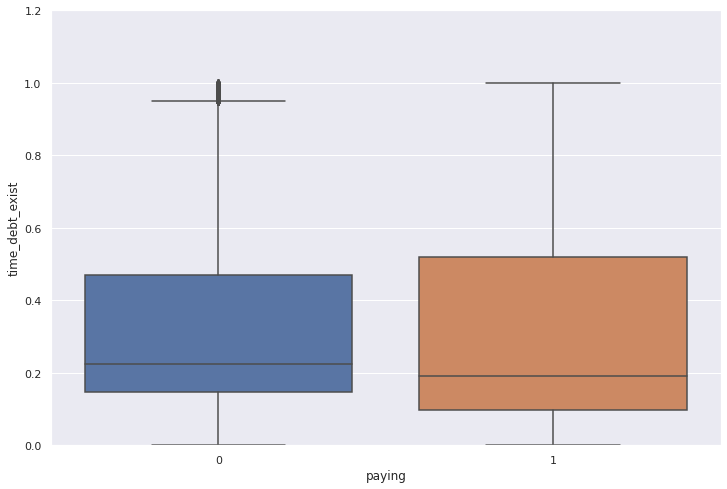

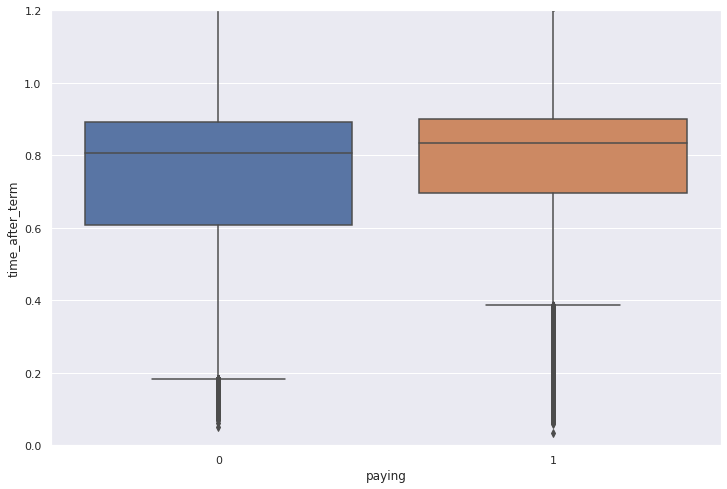

In [ ]:
num_feat_05 = ['time_debt_exist', 'time_after_term']

for f in num_feat_05:
  plt.figure(figsize=(12, 8))
  sns.boxplot(x=y, y=X[f])
  plt.ylim((0, 1.2))
  plt.show()

Measurement of correlation in a numerical feature set

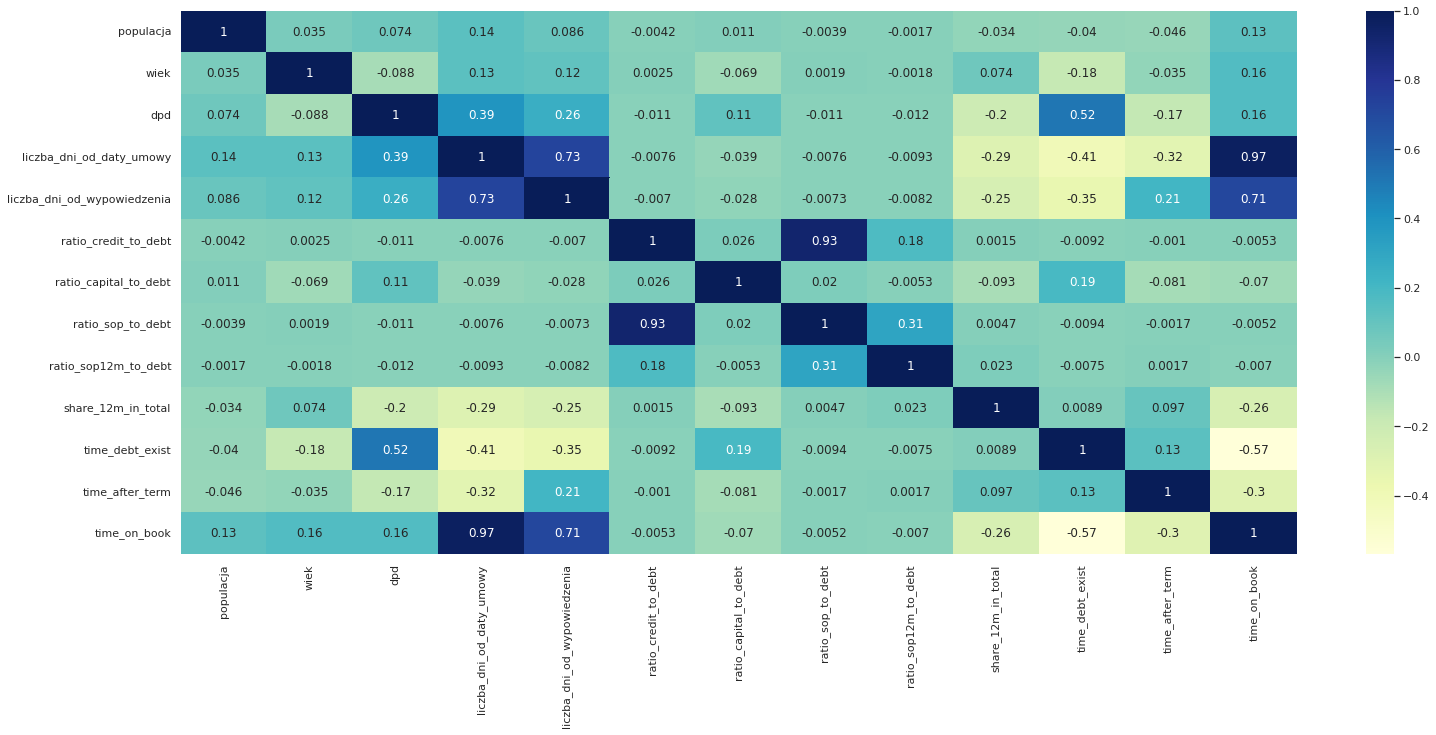

In [ ]:
sns.set(rc={"figure.figsize":(25, 10)})
data_corr = X[num_feat].corr()

dataplot = sns.heatmap(data_corr, cmap="YlGnBu", annot=True)
  
plt.show()

There's high correlation in feature pairs:
- time on book and liczba dni od daty umowy
- ratio_sop_to_debt and ratio_credit_to_debt
- liczba_dni_od_daty_umowy and liczba_dni_od_daty_wypowiedzenia
- dpd and time_debt_exist

The assumption for further processing is to leave all features (the set does not have many) and not to use dimensionality reduction (PCA, so as not to lose interpretability). Feature selection between explanatory variables will be used to reduce the high correlation.

Measurement correlation between numeric variables and target.

If we set the cut-off point at 0.15, apart from the variables wiek and ratio_capital_to_debt the rest are not correlated with the target.

P-value tells us if the result of an experiment is statistically significant in all cases (value < 0.05).

In [ ]:
for f in num_feat:
  print(f'\nFeature: {f}')
  print(stats.pointbiserialr(X[f], y))


Feature: populacja
PointbiserialrResult(correlation=-0.050284949754657, pvalue=1.6958144332250106e-63)

Feature: wiek
PointbiserialrResult(correlation=0.240911497248598, pvalue=0.0)

Feature: dpd
PointbiserialrResult(correlation=-0.12411904519945044, pvalue=0.0)

Feature: liczba_dni_od_daty_umowy
PointbiserialrResult(correlation=-0.08500371310204952, pvalue=2.801826624676731e-178)

Feature: liczba_dni_od_wypowiedzenia
PointbiserialrResult(correlation=-0.031210019021960144, pvalue=1.6897405992487762e-25)

Feature: ratio_credit_to_debt
PointbiserialrResult(correlation=-0.009676410966363916, pvalue=0.001216298180906387)

Feature: ratio_capital_to_debt
PointbiserialrResult(correlation=-0.26267110317976394, pvalue=0.0)

Feature: ratio_sop_to_debt
PointbiserialrResult(correlation=-0.009768749150876723, pvalue=0.0010911585121983552)

Feature: ratio_sop12m_to_debt
PointbiserialrResult(correlation=-0.0091354492904381, pvalue=0.0022568601359453547)

Feature: share_12m_in_total
PointbiserialrRes

Identifying the influence of categorical values to target

In [ ]:
display(data_all_01.groupby(['kategoria_produktu'])[['paying']].mean())
print()
display(data_all_01.groupby(['plec'])[['paying']].mean())
print()
display(data_all_01.groupby(['czy_wind_zewn'])[['paying']].mean())

,paying
kategoria_produktu,
Kredyt gotówkowy,0.540721
Pożyczka gotówkowa,0.554777
Produkty odnawialne,0.400575


,paying
plec,
K,0.604529
M,0.447193


,paying
czy_wind_zewn,
0,0.534620
1,0.458396


# Modelling and results

Spliting into training, validation, test subsets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100591, 16), (100591,), (11177, 16), (11177,))

## Baseline model

For binary classification problems, the simplest baseline model is predicting the most common class (or mode) of the outcome variable for all observations. In this case, we predict all cases in dataset would be 'paying'.

In [ ]:
baseline_model = DummyClassifier(strategy="most_frequent", random_state=3)

In [ ]:
baseline_model.fit(X_train, y_train)

DummyClassifier(random_state=3, strategy='most_frequent')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5262
           1       0.53      1.00      0.69      5915

    accuracy                           0.53     11177
   macro avg       0.26      0.50      0.35     11177
weighted avg       0.28      0.53      0.37     11177



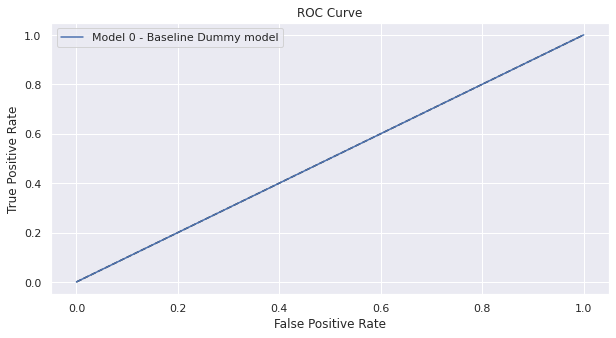

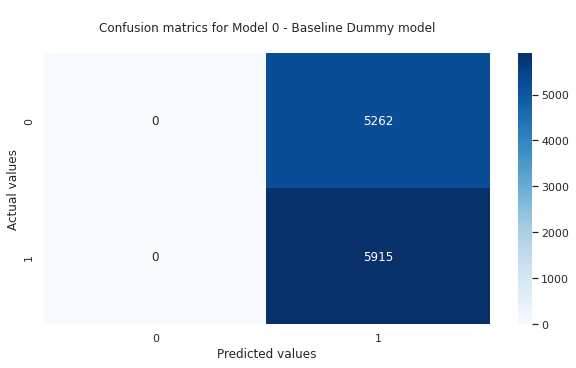

,Model,Accuracy,F1_score,AUC
0,Model 0 - Baseline Dummy model,0.529212,0.692137,0.5


In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(baseline_model, 'Model 0 - Baseline Dummy model')

## Model 1 - Decision Tree Classifier

In [ ]:
cat_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

num_transformer = Pipeline(steps=[
    ('passthrough', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_feat),
        ('num', num_transformer, num_feat)
         ])

dt_pipeline = Pipeline(steps=[  ('preprocessor', preprocessor),
                                 ('chi2_feat_sel', SelectPercentile(chi2)),
                                ('dt_model', DecisionTreeClassifier())])

print(dt_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'chi2_feat_sel', 'dt_model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__ohe', 'preprocessor__cat__ohe__categories', 'preprocessor__cat__ohe__drop', 'preprocessor__cat__ohe__dtype', 'preprocessor__cat__ohe__handle_unknown', 'preprocessor__cat__ohe__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__passthrough', 'preprocessor__num__passthrough__add_indicator', 'preprocessor__num__passthrough__copy', 'preprocessor__num__passthrough__fill_value', 'preprocessor__num__passthrough__missing_values', 'preprocessor__num__passthrough__strategy', 'preproces

In [ ]:
dt_model_param_grid = {   
                          'chi2_feat_sel__percentile': [70, 80, 90],
                          'dt_model__criterion': [ 'gini', 'entropy'],
                          'dt_model__max_features':['auto'],
                          'dt_model__max_depth': [6, 12, 15],
                          'dt_model__min_samples_split': [ 20, 25, 35],
                          'dt_model__min_samples_leaf': [  40, 50, 60, 70]
                      }

In [ ]:
dt_model_gridsearch = HalvingGridSearchCV( 
                                        estimator = dt_pipeline,
                                        param_grid = dt_model_param_grid,
                                        scoring='f1_macro',
                                        cv=10,
                                        verbose=1,
                                        n_jobs=-1,
                                        random_state=3)

dt_model_gridsearch.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1241
max_resources_: 100591
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 1241
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 72
n_resources: 3723
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 2
n_candidates: 24
n_resources: 11169
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 3
n_candidates: 8
n_resources: 33507
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 4
n_candidates: 3
n_resources: 100521
Fitting 10 folds for each of 3 candidates, totalling 30 fits


HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder())]),
                                                                                Index(['kategoria_produktu', 'plec', 'czy_wind_zewn'], dtype='object')),
                                                                               ('num',
                                                                                Pipeline(steps=[('passthrough',
                                                                                                 SimpleImputer(strategy='median'))]),
                                                                                ['populacja',
                      

In [ ]:
print('\nBest hyperparameter:', dt_model_gridsearch.best_params_)


Best hyperparameter: {'chi2_feat_sel__percentile': 80, 'dt_model__criterion': 'gini', 'dt_model__max_depth': 15, 'dt_model__max_features': 'auto', 'dt_model__min_samples_leaf': 60, 'dt_model__min_samples_split': 25}


In [ ]:
dt_model = dt_model_gridsearch.best_estimator_

              precision    recall  f1-score   support

           0       0.67      0.79      0.73      5262
           1       0.78      0.66      0.72      5915

    accuracy                           0.72     11177
   macro avg       0.73      0.72      0.72     11177
weighted avg       0.73      0.72      0.72     11177



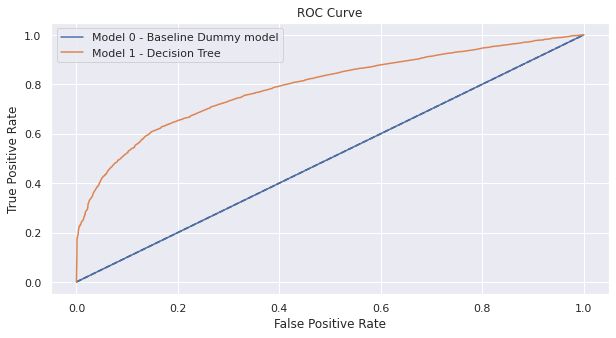

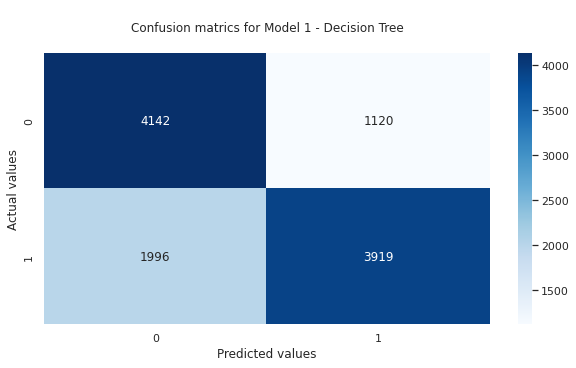

,Model,Accuracy,F1_score,AUC
0,Model 0 - Baseline Dummy model,0.529212,0.692137,0.500000
1,Model 1 - Decision Tree,0.721213,0.715538,0.789896


In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(dt_model, 'Model 1 - Decision Tree')

**SHapley Additive exPlanations**

In [ ]:
used_columns = list(dt_model.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names()) + num_feat

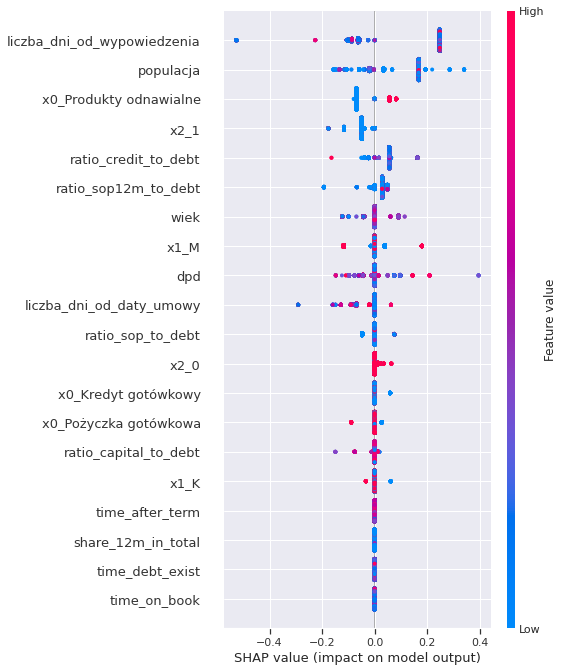

None

In [ ]:
explainer = shap.TreeExplainer(dt_model.named_steps['dt_model'])

shap_values = explainer.shap_values(pd.DataFrame(dt_model['preprocessor'].transform(X_test), columns=used_columns), approximate=True)

p = shap.summary_plot(shap_values[1], pd.DataFrame(dt_model['preprocessor'].transform(X_test), columns=used_columns))

shap.initjs()
display(p)

The features most influencing the results of this model were: liczba_dni_od_wypowiedzenia, populacja, kategoria_produktu, the conduct of external debt collection, the ratio capital to debt.
On the other hand, virtually 4 features were not included.

## Model 2 - Random Forest Classifier

In [ ]:
cat_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

num_transformer = Pipeline(steps=[
    ('passthrough', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_feat),
        ('num', num_transformer, num_feat)
         ])

rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('chi2_feat_sel', SelectPercentile(chi2)),
                              ('rfc_model', RandomForestClassifier())])

print(rfc_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'chi2_feat_sel', 'rfc_model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__ohe', 'preprocessor__cat__ohe__categories', 'preprocessor__cat__ohe__drop', 'preprocessor__cat__ohe__dtype', 'preprocessor__cat__ohe__handle_unknown', 'preprocessor__cat__ohe__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__passthrough', 'preprocessor__num__passthrough__add_indicator', 'preprocessor__num__passthrough__copy', 'preprocessor__num__passthrough__fill_value', 'preprocessor__num__passthrough__missing_values', 'preprocessor__num__passthrough__strategy', 'preproce

In [ ]:
rfc_model_param_grid = {
              'chi2_feat_sel__percentile': [80, 90, 95],
              'rfc_model__criterion': [ 'gini'],
              'rfc_model__max_features':['auto'],
              'rfc_model__max_depth': [18, 20, 22],
              'rfc_model__min_samples_split': [2, 5, 10],
              'rfc_model__min_samples_leaf': [2, 6, 10],
              'rfc_model__n_estimators': [1200, 1400, 1600]
              }

In [ ]:
rfc_model_gridsearch = HalvingGridSearchCV(estimator = rfc_pipeline,
                                       param_grid = rfc_model_param_grid,
                                       scoring='f1_macro',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=3,
                                       refit=True)

rfc_model_gridsearch.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', rfc_model_gridsearch.best_params_)


Best hyperparameter: {'chi2_feat_sel__percentile': 80, 'rfc_model__criterion': 'gini', 'rfc_model__max_depth': 22, 'rfc_model__max_features': 'auto', 'rfc_model__min_samples_leaf': 6, 'rfc_model__min_samples_split': 10, 'rfc_model__n_estimators': 1400}


In [ ]:
rfc_model = rfc_model_gridsearch.best_estimator_

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      5262
           1       0.80      0.70      0.75      5915

    accuracy                           0.75     11177
   macro avg       0.75      0.75      0.75     11177
weighted avg       0.76      0.75      0.75     11177



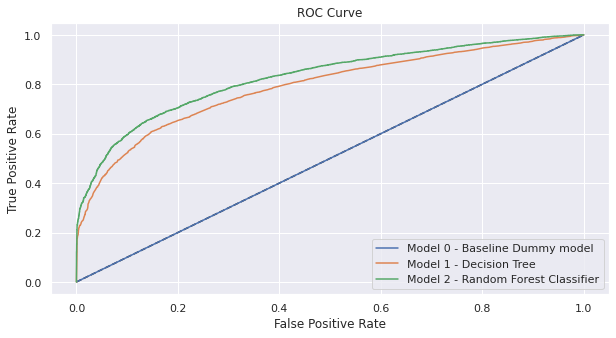

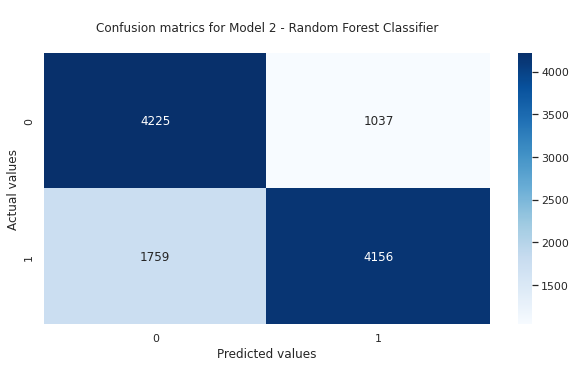

,Model,Accuracy,F1_score,AUC
0,Model 0 - Baseline Dummy model,0.529212,0.692137,0.500000
1,Model 1 - Decision Tree,0.721213,0.715538,0.789896
2,Model 2 - Random Forest Classifier,0.749843,0.748290,0.827869


In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(rfc_model, 'Model 2 - Random Forest Classifier')

**SHapley Additive exPlanations**

In [ ]:
used_columns = list(rfc_model.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names()) + num_feat

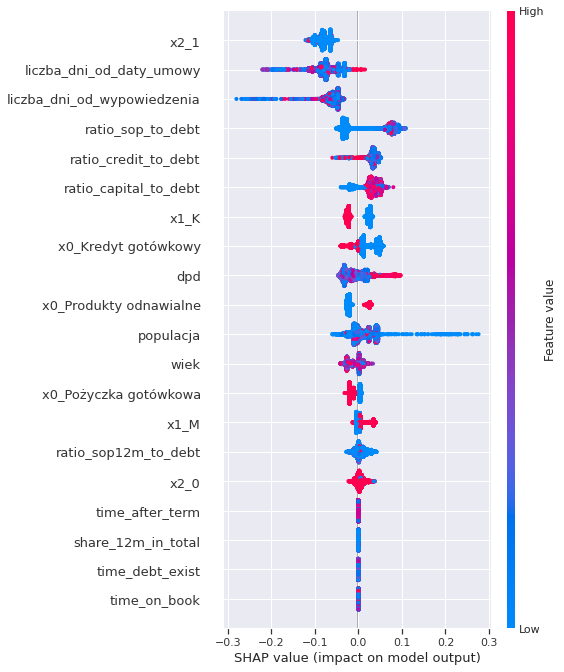

None

In [ ]:
explainer = shap.TreeExplainer(rfc_model.named_steps['rfc_model'])

shap_values = explainer.shap_values(pd.DataFrame(rfc_model['preprocessor'].transform(X_test), columns=used_columns), approximate=True)

p = shap.summary_plot(shap_values[1], pd.DataFrame(rfc_model['preprocessor'].transform(X_test), columns=used_columns))

shap.initjs()
display(p)

The features most influencing the results of this model were:
the conduct of external debt collection, the number of days since origination, the number of days since termination, the ratio of the sum of payments to the amount of the debt, the ratio credit to debt. 

On the other hand, virtually 4 features were not included.

## Model 3 - XGBoost Classifier

In [ ]:
cat_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

num_transformer = Pipeline(steps=[
    ('passthrough', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_feat),
        ('num', num_transformer, num_feat)
         ])

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('chi2_feat_sel', SelectPercentile(chi2)),
                              ('xgb_model', XGBClassifier())])

print(xgb_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'chi2_feat_sel', 'xgb_model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__ohe', 'preprocessor__cat__ohe__categories', 'preprocessor__cat__ohe__drop', 'preprocessor__cat__ohe__dtype', 'preprocessor__cat__ohe__handle_unknown', 'preprocessor__cat__ohe__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__passthrough', 'preprocessor__num__passthrough__add_indicator', 'preprocessor__num__passthrough__copy', 'preprocessor__num__passthrough__fill_value', 'preprocessor__num__passthrough__missing_values', 'preprocessor__num__passthrough__strategy', 'preproce

In [ ]:
xgb_param_grid = { 
              'chi2_feat_sel__percentile': [70, 80, 90],
              'xgb_model__max_depth': [2, 6, 12],
              'xgb_model__learning_rate':  [0.01, 0.1, 0.3 ],
              'xgb_model__gamma': [3, 5, 7, 9],
              'xgb_model__subsample': [0.7, 0.8, 0.9],
              'xgb_model__colsample_bytree' : [0.7, 0.8, 0.9, 0.95],
              'xgb_model__objective' : ['binary:logistic']
              }

In [ ]:
xgb_model_gridsearch = HalvingGridSearchCV(estimator = xgb_pipeline,
                                       param_grid = xgb_param_grid,
                                       scoring='f1_macro',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=3,
                                       refit=True)

xgb_model_gridsearch.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', xgb_model_gridsearch.best_params_)


Best hyperparameter: {'chi2_feat_sel__percentile': 80, 'xgb_model__colsample_bytree': 0.9, 'xgb_model__gamma': 7, 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 12, 'xgb_model__objective': 'binary:logistic', 'xgb_model__subsample': 0.8}


In [ ]:
xgb_model = xgb_model_gridsearch.best_estimator_

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      5262
           1       0.80      0.70      0.75      5915

    accuracy                           0.75     11177
   macro avg       0.76      0.76      0.75     11177
weighted avg       0.76      0.75      0.75     11177



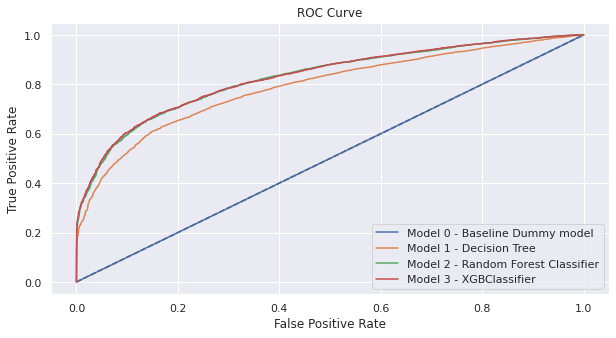

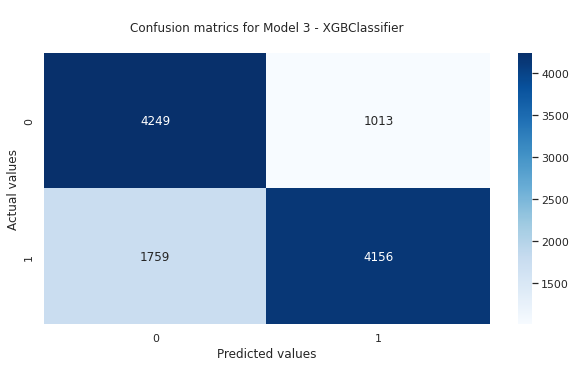

,Model,Accuracy,F1_score,AUC
0,Model 0 - Baseline Dummy model,0.529212,0.692137,0.500000
1,Model 1 - Decision Tree,0.721213,0.715538,0.789896
2,Model 2 - Random Forest Classifier,0.749843,0.748290,0.827869
3,Model 3 - XGBClassifier,0.751991,0.749910,0.829509


In [ ]:
calculation_metrics(xgb_model, 'Model 3 - XGBClassifier')

# Final results

In [ ]:
display(metrics_dataframe)

,Model,Accuracy,F1_score,AUC
0,Model 0 - Baseline Dummy model,0.529212,0.692137,0.500000
1,Model 1 - Decision Tree,0.721213,0.715538,0.789896
2,Model 2 - Random Forest Classifier,0.749843,0.748290,0.827869
3,Model 3 - XGBClassifier,0.751991,0.749910,0.829509


# Saving the model for business use

In [ ]:
joblib.dump(rfc_model, 'drive/MyDrive/1.Projekt_koncowy/rfc_model_3.pkl', compress=1)

['drive/MyDrive/1.Projekt_koncowy/rfc_model_3.pkl']